# Initialization

In [1]:
%load_ext autoreload
%load_ext line_profiler
import sys
sys.path.append("..")

In [2]:
%autoreload

import numpy as np
import pickle

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]

import main

import darkhistory.physics as phys
import darkhistory.utilities as utils

from darkhistory.spec import spectools
from darkhistory.spec.spectrum import Spectrum

from scipy.interpolate import interp2d
from astropy.io import fits


In [3]:
direc = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/complete/'

(highengphot_tf_interp,
     lowengphot_tf_interp,
     lowengelec_tf_interp,
     highengdep_interp,
     CMB_engloss_interp
    ) = main.load_trans_funcs(direc)

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
Done.



In [4]:
ics_thomson_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_thomson_ref_tf.raw", "rb")) 
ics_rel_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_rel_ref_tf.raw", "rb"))
engloss_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/engloss_ref_tf.raw", "rb"))

# f(z) Data Upload

In [5]:
direc = '/Users/hongwan/Dropbox (MIT)/'
fz_elec_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs  = fz_phot_decay[0:70, 1]
log10eng = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}

In [6]:
log10f_tmp = log10f_phot_decay

def f_H_ion(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['H_ion'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_He_ion(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['He_ion'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_H_exc(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['H_exc'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_heating(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['heating'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_cont(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['cont'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

# `main.evolve` Tests

## $m_\chi = 2 \times 10^{12}$ eV, $\chi \to \gamma \gamma$

### Load Reference Files

In [7]:
# hdul = fits.open(
#     '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/calculated_fractions_phot_logE_1.230E+01.fits'
# )
# data = hdul[1].data

# idl_redshift = data.field('redshift')[0]
# idl_loweng_deposition_fractions = data.field('loweng_deposition_fractions')[0]
# idl_higheng_deposition_fractions = data.field('higheng_deposition_fractions')[0]

# f_idl = idl_loweng_deposition_fractions + idl_higheng_deposition_fractions

hdul = fits.open(
    '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/tf_z_3.000E+03_nstep_6622_logE_1.230E+01_xe_0.000E+00.fits'
)
data = hdul[1].data

idl_redshift = data.field('redshift')[0]
# idl_photonspectrum = data.field('photonspectrum')[0]
# idl_lowengphot = data.field('lowengphot')[0]
# idl_lowengelec = data.field('lowengelec')[0]


In [ ]:
idl_redshift

### Evolution Cell

In [8]:
eleceng = lowengelec_tf_interp.eng
photeng = lowengphot_tf_interp.eng

# Due to configuration issues, specifying mwimp=2e12 with tau = 1e25
# in the main code actually translates into an *actual* mDM=4e12, with
# tau = 0.5e25.
mDM = 4e12
tau = 0.5e25

# kinetic energy!
# elec_spec_init = spectools.rebin_N_arr(np.array([2]), np.array([(mDM - 2*phys.me)/2]), eleceng)
# elec_spec_init.rs = 3000

# phot_spec_init = Spectrum(photeng, np.zeros_like(photeng), rs = 3000)

# find the uppermost bin to perform the injection.
# inject mDM/2/eng_delta_inj particles.
injE = photeng[photeng < mDM/2][-1]

phot_spec_init = spectools.rebin_N_arr(np.array([2*mDM/2/injE]), np.array([injE]), photeng)
phot_spec_init.rs = 3000

elec_spec_init = Spectrum(eleceng, np.zeros_like(eleceng), rs=3000)

if elec_spec_init.spec_type == 'dNdE':
    elec_spec_init.switch_spec_type()
if phot_spec_init.spec_type == 'dNdE':
    phot_spec_init.switch_spec_type()
    
def rate_func_N(rs):
    return phys.rho_DM*rs**3/tau/mDM

def rate_func_eng(rs):
    return phys.rho_DM*rs**3/tau

b_4e12 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 4,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp, ics_only=False,
    ics_thomson_ref_tf=ics_thomson_ref_tf, ics_rel_ref_tf=ics_rel_ref_tf, engloss_ref_tf=engloss_ref_tf,
    coarsen_factor=1,std_soln=True, user=None, verbose=False, use_tqdm=True
)



AHHHH YEAHHHH!



### Spectrum Comparison

In [19]:
# pickle.dump(b_4e12, open("/Users/hongwan/Desktop/b_4e12.raw", "wb"))
b_4e12 = pickle.load(open("/Users/hongwan/Desktop/b_4e12.raw", "rb"))

In [ ]:
i = 1

plt.figure()
ax = plt.gca()
ax.loglog()

plt.axis([1e-4, 5e12, 1e-30, 1e-10])

# plt.plot(photeng, b_4e12[2].grid_vals[i])
plt.plot(photeng, idl_photonspectrum[i])

### $f(z)$ Plots

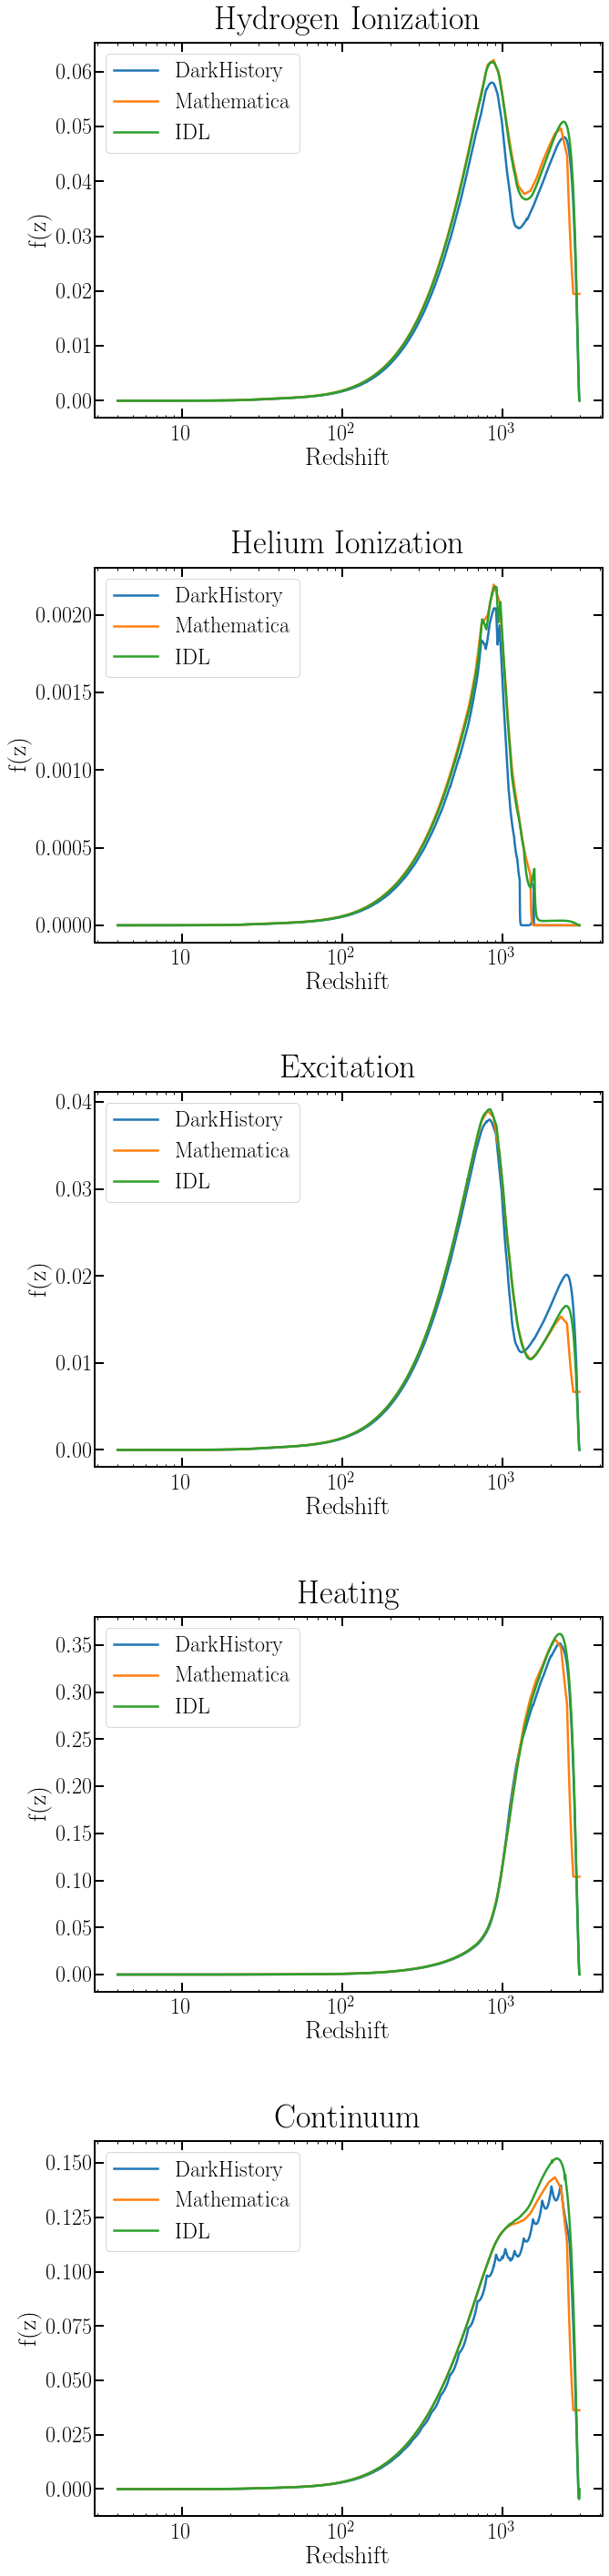

In [127]:
injE = photeng[photeng < mDM/2][-1]
    

f_H_ion_vec_math   = [f_H_ion(rs, injE) for rs in rs_vec[1:]]
f_He_ion_vec_math  = [f_He_ion(rs, injE) for rs in rs_vec[1:]]
f_exc_vec_math     = [f_H_exc(rs, injE) for rs in rs_vec[1:]]
f_heat_vec_math    = [f_heating(rs, injE) for rs in rs_vec[1:]]
f_cont_vec_math    = [f_cont(rs, injE) for rs in rs_vec[1:]]

f_vec_math = np.vstack([
    f_H_ion_vec_math, f_He_ion_vec_math, 
    f_exc_vec_math, f_heat_vec_math, 
    f_cont_vec_math
])

plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
    ax.set_xscale('log')
#     ax.set_yscale('log')
    plt.xlabel('Redshift')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization')
    elif i == 1:
        plt.title('Helium Ionization')
    elif i == 2:
        plt.title('Excitation')
    elif i == 3:
        plt.title('Heating')
    elif i == 4:
        plt.title('Continuum')
    plt.plot(rs_vec[1:], b_4e12[5][:,i], label='DarkHistory')
    plt.plot(rs_vec[1:], f_vec_math[i], label='Mathematica')
    plt.plot(rs_vec, f_idl[i], label='IDL')
    plt.legend()


## $m_\chi = 2 \times 10^{5}$ eV, $\chi \to \gamma \gamma$

### Evolution Cell

In [106]:
eleceng = lowengelec_tf_interp.eng
photeng = lowengphot_tf_interp.eng

mDM = 2e5
tau = 3e25

# kinetic energy!
# elec_spec_init = spectools.rebin_N_arr(np.array([2]), np.array([(mDM - 2*phys.me)/2]), eleceng)
# elec_spec_init.rs = 3000

# phot_spec_init = Spectrum(photeng, np.zeros_like(photeng), rs = 3000)

phot_spec_init = spectools.rebin_N_arr(np.array([2]), np.array([mDM/2]), photeng)
phot_spec_init.rs = 3000

elec_spec_init = Spectrum(eleceng, np.zeros_like(eleceng), rs=3000)

if elec_spec_init.spec_type == 'dNdE':
    elec_spec_init.switch_spec_type()
if phot_spec_init.spec_type == 'dNdE':
    phot_spec_init.switch_spec_type()
    
def rate_func_N(rs):
    return phys.rho_DM*rs**3/tau/mDM

def rate_func_eng(rs):
    return phys.rho_DM*rs**3/tau

b_2e5 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 4,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp, ics_only=False,
    ics_thomson_ref_tf=ics_thomson_ref_tf, ics_rel_ref_tf=ics_rel_ref_tf, engloss_ref_tf=engloss_ref_tf,
    coarsen_factor=1,std_soln=True, user=None, verbose=False, use_tqdm=True
)



AHHHH YEAHHHH!


### $f(z)$ Plots

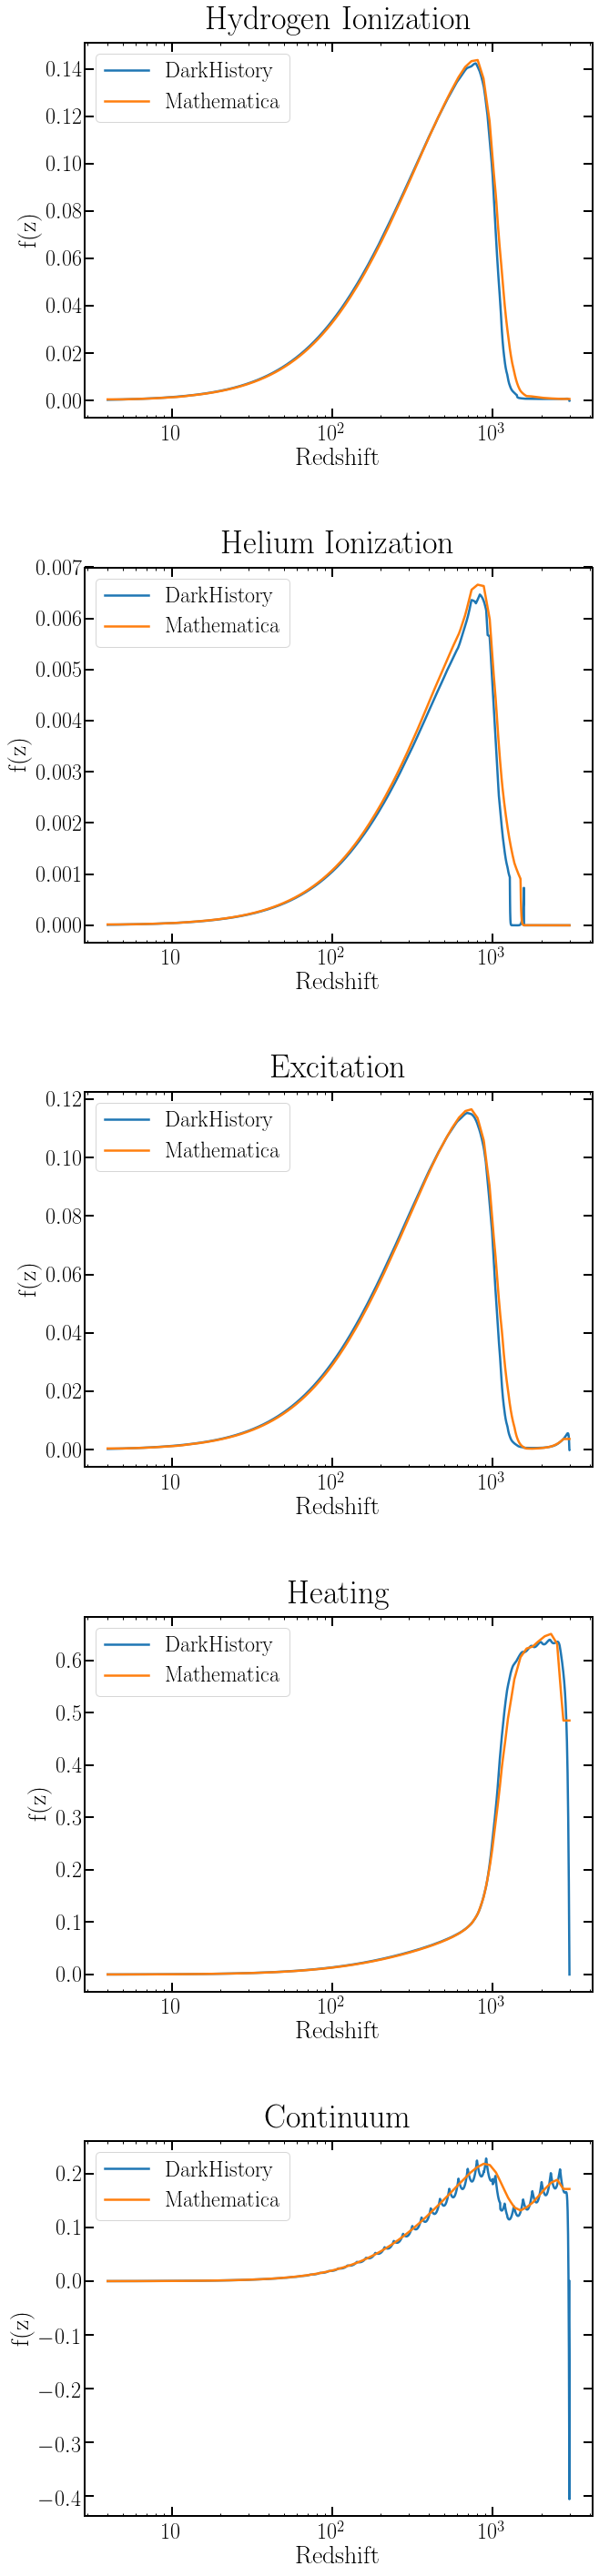

In [107]:


rs_vec = b_2e5[3].rs
injE = mDM/2
    

f_H_ion_vec   = [f_H_ion(rs, injE) for rs in rs_vec[1:]]
f_He_ion_vec  = [f_He_ion(rs, injE) for rs in rs_vec[1:]]
f_exc_vec     = [f_H_exc(rs, injE) for rs in rs_vec[1:]]
f_heat_vec    = [f_heating(rs, injE) for rs in rs_vec[1:]]
f_cont_vec    = [f_cont(rs, injE) for rs in rs_vec[1:]]

f_vec = np.vstack([f_H_ion_vec, f_He_ion_vec, f_exc_vec, f_heat_vec, f_cont_vec])

plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel('Redshift')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization')
    elif i == 1:
        plt.title('Helium Ionization')
    elif i == 2:
        plt.title('Excitation')
    elif i == 3:
        plt.title('Heating')
    elif i == 4:
        plt.title('Continuum')
    plt.plot(rs_vec[1:], b_2e5[5][:,i], label='DarkHistory')
    plt.plot(rs_vec[1:], f_vec[i], label='Mathematica')
    plt.legend()
